<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [17]:
%matplotlib notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

from fastprogress.fastprogress import master_bar, progress_bar

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from jupyterthemes import jtplot
from IPython.display import HTML

from functools import partial

jtplot.style(context="talk")

In [2]:
def loss_landscape_function(X, size):
    """Generate a pretty loss landscape."""

    # Portion below x-y plane (l < 0)
    l1 = size * torch.exp(-(X ** 2).sum(dim=1) / 2) / (2 * torch.pi)

    # Portion above x-y plane (l > 0)
    shift = torch.tensor([1.5, 0.5])
    l2 = size * torch.exp(-(((X - 1) / shift) ** 2).sum(dim=1) / 2) / (1.5 * torch.pi)

    return 1.5 * (l2 - l1)


def loss_landscape_plot_data(size, step=0.1):
    x1 = x2 = torch.arange(-size, size, step)
    X1, X2 = torch.meshgrid(x1, x2, indexing="ij")
    X = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=1)
    L = loss_landscape_function(X, size).reshape_as(X1)
    return X1, X2, L


def plot_loss_landscape(size, ax=None, step=0.1):

    if ax == None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(projection="3d")

    X1, X2, L = loss_landscape_plot_data(size, step)
    ax.contourf(X1, X2, L, zdir="z", offset=-1, zorder=2)
    ax.plot_surface(X1, X2, L, zorder=1)
    

    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_zlim(-1, 1)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    ax.set_xlabel("Parameter 1")
    ax.set_ylabel("Parameter 2")
    ax.set_zlabel("Loss")

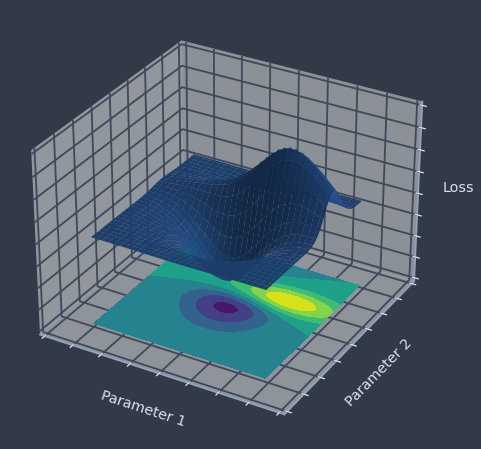

In [3]:
plot_loss_landscape(3)

In [4]:
def train(size, opt_func, learning_rate, num_epochs=100):

    # Parameters
    W = torch.tensor([[1.5, 1.0]], requires_grad=True)
    optimizer = opt_func([W], lr=learning_rate)
    criterion = torch.nn.MSELoss()

    w1 = []
    w2 = []
    ls = []

    for epoch in range(num_epochs):
        # Compute loss
        loss = loss_landscape_function(W, size)

        # Save parameters and loss for plots
        w1.append(W[0][0].item())
        w2.append(W[0][1].item())
        ls.append(loss.item() + 0.05)  # shift up for plots

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return w1, w2, ls


lrs = [0.01, 0.1]

opt_funcs = {
    "SGD": torch.optim.SGD,
    "SGD+Momentum": partial(torch.optim.SGD, momentum=0.9),
    "RMSProp": torch.optim.RMSprop,
    "Adam": torch.optim.Adam,
}

size = 3

results = {}
for lr in lrs:
    for opt in opt_funcs:
        results[f"lr={lr}, {opt}"] = train(size, opt_funcs[opt], lr)

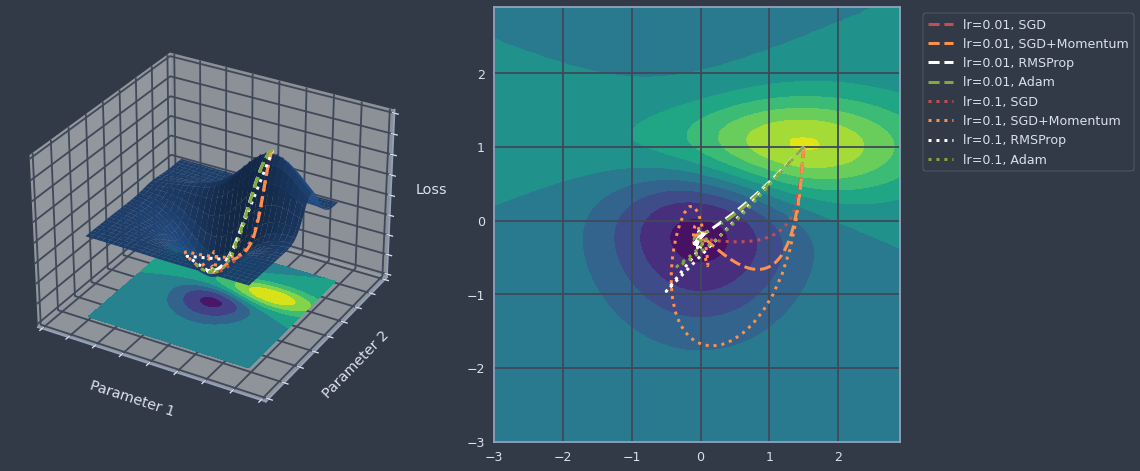

In [5]:
fig = plt.figure(figsize=(16, 8))

ax_3d = fig.add_subplot(1, 2, 1, projection="3d")
plot_loss_landscape(size, ax_3d)

ax_2d = fig.add_subplot(1, 2, 2)
X1, X2, L = loss_landscape_plot_data(size)
ax_2d.contourf(X1, X2, L, levels=10)

colors = ["r--", "y--", "w--", "g--", "r:", "y:", "w:", "g:"]

for res, color in zip(results, colors):
    w1, w2, ls = results[res]
    ax_3d.plot(w1, w2, ls, color, linewidth=3, zorder=11)
    ax_2d.plot(w1, w2, color, linewidth=3, label=res)

_ = ax_2d.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

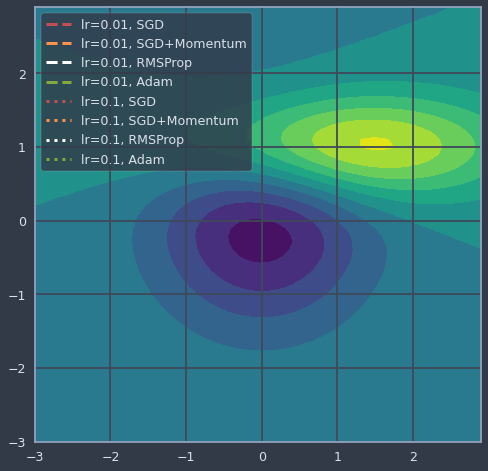

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.contourf(X1, X2, L, levels=10)

lines = []
for res, color in zip(results, colors):
    lines.append(ax.plot([], [], color, linewidth=3, label=res)[0])

ax.legend(loc="upper left")

def animate(frame):
    for res, line in zip(results, lines):
        w1, w2, _ = results[res]
        line.set_data(w1[:frame], w2[:frame])
    return lines


animation = FuncAnimation(fig, animate, len(w1))

In [7]:
HTML(animation.to_jshtml())

In [8]:
# animation.save("optimization.mp4")